# Lab 2: Hamiltonian Monte Carlo

In this lab, we'll implement Hamiltonian Monte Carlo (HMC) from scratch using JAX and compare it to a basic random walk Metropolis sampler.

**What's HMC?**
HMC is a Markov Chain Monte Carlo (MCMC) method that uses gradient information to make intelligent proposals. Instead of random walks, HMC simulates Hamiltonian dynamics. This lets HMC:

-   Make large moves while maintaining higher acceptance rates
-   Efficiently explore distributions with complex geometry (correlations, curved modes)
-   Scale much better to higher dimensions than random walk methods

**Learning objectives:**

-   Understand the mechanics of the leapfrog integrator
-   Implement HMC and gain more familiarity with JAX
-   Gain intuition for MCMC hyperparameters (step size, trajectory length)


In [1]:
!pip install -r requirements.txt

In [12]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np

from jax import grad, jit

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Part A: The Target Distribution (~5 min)

We'll sample from a challenging distribution: **four banana-shaped modes** arranged symmetrically. This is difficult for random walk samplers because:

1. **Mode separation**: The modes are far apart, so a random walk must take many small steps to move between them
2. **Curved geometry**: Each mode is banana-shaped, so even within a mode, random walks struggle to follow the curved high-probability region

HMC can handle both challenges by using gradient information to make informed proposals that follow the geometry.

### tsing's notes:

-   modes are the highest point of the distribution
    -> multimodal distribution has multiple peaks ^^ in this case it has 4
-


In [3]:
def log_prob(theta):
    """Four banana-shaped modes log-probability.

    Args:
        theta: Array of shape (2,) containing [x, y] coordinates

    Returns:
        Log probability (unnormalized)
    """
    x, y = theta[0], theta[1]
    a, b = 0.5, 1.0  # Banana curvature params
    d = 3.5  # Mode separation

    # Four banana modes pointing outward from origin
    log_ps = jnp.array(
        [
            -0.5 * ((x - d) ** 2 + ((y - d) - a * (x - d) ** 2) ** 2 / b),  # top-right
            -0.5 * ((x + d) ** 2 + ((y - d) + a * (x + d) ** 2) ** 2 / b),  # top-left
            -0.5 * ((x - d) ** 2 + ((y + d) + a * (x - d) ** 2) ** 2 / b),  # bottom-right
            -0.5 * ((x + d) ** 2 + ((y + d) - a * (x + d) ** 2) ** 2 / b),  # bottom-left
        ]
    )

    return jax.scipy.special.logsumexp(log_ps)

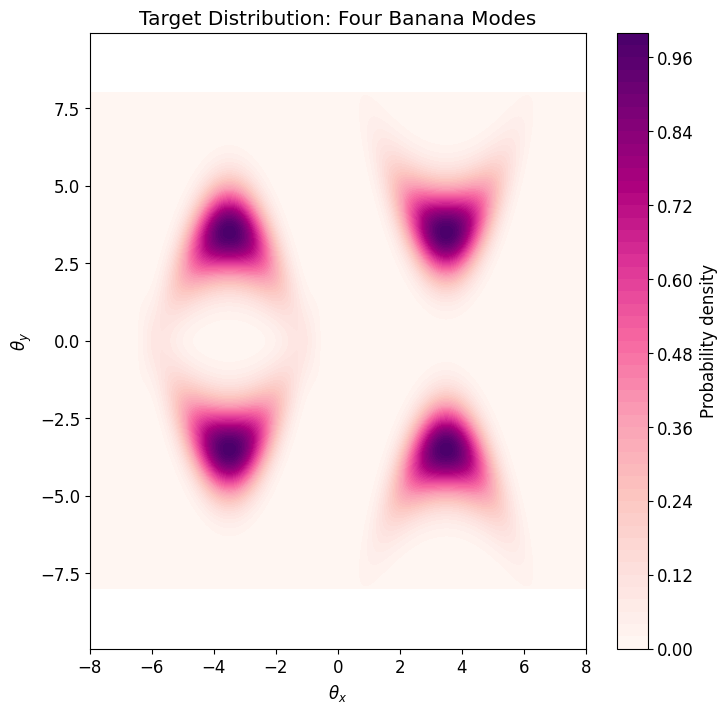

In [4]:
# Visualize the target distribution
x = jnp.linspace(-8, 8, 200)
y = jnp.linspace(-8, 8, 200)
X, Y = jnp.meshgrid(x, y)
positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

# Evaluate log prob at each point
log_probs = jax.vmap(log_prob)(positions).reshape(X.shape)

plt.figure(figsize=(8, 8))
plt.contourf(X, Y, jnp.exp(log_probs), levels=50, cmap="RdPu")
plt.colorbar(label="Probability density")
plt.xlabel(r"$\theta_x$")
plt.ylabel(r"$\theta_y$")
plt.title("Target Distribution: Four Banana Modes")
plt.axis("equal")
plt.show()

---

## Part B: Random Walk Metropolis (~5 min)

First, let's implement a baseline: the **random walk Metropolis** algorithm. This is the simplest MCMC method:

1. **Propose**: From current position $\theta$, propose $\theta' \sim \mathcal{N}(\theta, \sigma^2 I)$
2. **Accept/Reject**: Accept with probability $\alpha = \min\left(1, \frac{p(\theta' \mid x)}{p(\theta \mid x)}\right) = \min\left(1, \frac{p(x \mid \theta') \, p(\theta')}{p(x \mid \theta) \, p(\theta)}\right)$

The proposal is isotropic — it doesn't know anything about the geometry of the distribution.


In [5]:
def rw_step(key, theta, log_prob_fn, step_size):
    """Single random walk Metropolis step.

    Args:
        key: JAX random key
        theta: Current position, shape (D,)
        log_prob_fn: Function that returns log probability
        step_size: Standard deviation of Gaussian proposal

    Returns:
        new_theta: New position (may be same as old if rejected)
        accepted: Boolean indicating if proposal was accepted
    """
    key1, key2 = jr.split(key)

    # Propose: add Gaussian noise
    theta_prop = theta + step_size * jr.normal(key1, shape=theta.shape)

    # Compute log acceptance probability
    log_alpha = log_prob_fn(theta_prop) - log_prob_fn(theta)

    # Accept or reject
    u = jr.uniform(key2)
    accepted = jnp.log(u) < log_alpha

    new_theta = jnp.where(accepted, theta_prop, theta)
    return new_theta, accepted


def run_rw_sampler(key, log_prob_fn, theta_init, n_samples, step_size):
    """Run random walk Metropolis sampler.

    Args:
        key: JAX random key
        log_prob_fn: Function that returns log probability
        theta_init: Initial position, shape (D,)
        n_samples: Number of samples to generate
        step_size: Standard deviation of Gaussian proposal

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    keys = jr.split(key, n_samples)

    # JIT compile with log_prob_fn captured in closure
    @jit
    def jit_rw_step(key, theta):
        return rw_step(key, theta, log_prob_fn, step_size)

    # scan_fn: takes carry (current theta) and input (random key),
    # returns new carry (updated theta) and output (theta, accepted) to collect
    def scan_fn(theta, key):
        new_theta, accepted = jit_rw_step(key, theta)
        return new_theta, (new_theta, accepted)

    _, (samples, accepted) = jax.lax.scan(scan_fn, theta_init, keys)
    acceptance_rate = accepted.mean()

    return samples, acceptance_rate

In [6]:
# Test the random walk sampler
key = jr.PRNGKey(42)
theta_init = jnp.array([3.5, 3.5])  # Start near one mode

rw_samples, rw_acceptance = run_rw_sampler(key, log_prob, theta_init, n_samples=10000, step_size=1.0)

print(f"Random Walk acceptance rate: {rw_acceptance:.2%}")

Random Walk acceptance rate: 52.75%


---

## Part C: Implement HMC (~20 min)

Now it's your turn! HMC improves on random walk by simulating Hamiltonian dynamics.

### The Physics Picture

Imagine a ball rolling on a surface where height = $-\log p(\theta)$. We augment our parameters $\theta$ with "momentum" variables $\rho$ and define the **Hamiltonian** (total energy):

$$H(\theta, \rho) = \underbrace{-\log p(\theta \mid x)}_{\text{potential energy } U(\theta)} + \underbrace{\frac{1}{2}\rho^T\rho}_{\text{kinetic energy } K(\rho)}$$

### The Leapfrog Integrator

To simulate the dynamics, we use the **leapfrog integrator**. For each step:

$$\rho_{t+\epsilon/2} = \rho_t + \frac{\epsilon}{2} \nabla \log p(\theta_t \mid x) \quad \text{(half step for momentum)}$$
$$\theta_{t+\epsilon} = \theta_t + \epsilon \cdot \rho_{t+\epsilon/2} \quad \text{(full step for position)}$$
$$\rho_{t+\epsilon} = \rho_{t+\epsilon/2} + \frac{\epsilon}{2} \nabla \log p(\theta_{t+\epsilon} \mid x) \quad \text{(half step for momentum)}$$

### The HMC Algorithm

1. Sample fresh momentum: $\rho \sim \mathcal{N}(0, I)$
2. Compute initial Hamiltonian: $H(\theta, \rho) = -\log p(\theta \mid x) + \frac{1}{2}\rho^T\rho$
3. Run leapfrog for $L$ steps with step size $\epsilon$ to get proposal $(\theta', \rho')$
4. Compute proposed Hamiltonian: $H(\theta', \rho')$
5. Accept with probability $\alpha = \min\left(1, \exp(-\Delta H)\right)$ where $\Delta H = H(\theta', \rho') - H(\theta, \rho)$

### Your Task

Open `hmc.py` and implement the two functions:

1. `leapfrog(theta, rho, log_prob_fn, epsilon, L)` — the leapfrog integrator
2. `hmc_step(key, theta, log_prob_fn, epsilon, L)` — the full HMC transition


In [16]:
from hmc import leapfrog, hmc_step

In [19]:
# This function uses your hmc_step implementation
def run_hmc_sampler(key, log_prob_fn, theta_init, n_samples, epsilon, L):
    """Run HMC sampler.
    Args:
        key: JAX random key
        log_prob_fn: Function that returns log probability
        theta_init: Initial position, shape (D,)
        n_samples: Number of samples to generate
        epsilon: Leapfrog step size
        L: Number of leapfrog steps per HMC iteration

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    keys = jr.split(key, n_samples)

    # JIT compile the step function for speed
    @jit
    def jit_hmc_step(key, theta):
        return hmc_step(key, theta, log_prob_fn, epsilon, L)

    # scan_fn: takes carry (current theta) and input (random key),
    # returns new carry (updated theta) and output (theta, accepted) to collect
    def scan_fn(theta, key):
        new_theta, accepted = jit_hmc_step(key, theta)
        return new_theta, (new_theta, accepted)

    _, (samples, accepted) = jax.lax.scan(scan_fn, theta_init, keys)
    acceptance_rate = accepted.mean()

    return samples, acceptance_rate

### Test Your Implementation

Run the cells below to test. If correct, you should see:

-   Leapfrog conserves energy (small $|\Delta H|$)
-   HMC produces samples with correct statistics


In [20]:

# Test 1: Leapfrog should conserve energy on a simple Gaussian
def test_leapfrog_energy():
    """Test that leapfrog approximately conserves energy."""

    def simple_log_prob(theta):
        return -0.5 * jnp.sum(theta**2)

    theta0 = jnp.array([1.0, 0.5])
    rho0 = jnp.array([0.5, -0.3])

    # Initial energy
    H0 = -simple_log_prob(theta0) + 0.5 * jnp.sum(rho0**2)

    # Run leapfrog
    theta_new, rho_new = leapfrog(theta0, rho0, simple_log_prob, epsilon=0.1, L=50)

    # Final energy
    H1 = -simple_log_prob(theta_new) + 0.5 * jnp.sum(rho_new**2)

    energy_error = jnp.abs(H1 - H0)
    print(f"Initial energy: {H0:.6f}")
    print(f"Final energy:   {H1:.6f}")
    print(f"Energy error:   {energy_error:.6f}")

    if energy_error < 0.01:
        print("\n✓ Leapfrog test PASSED")
    else:
        print("\n✗ Leapfrog test FAILED - energy not conserved")


test_leapfrog_energy()

Initial energy: 0.795000
Final energy:   0.793716
Energy error:   0.001284

✓ Leapfrog test PASSED


In [21]:
# Test 2: HMC should produce correct samples on a simple Gaussian
def test_hmc_samples():
    """Test that HMC produces samples with correct mean."""
    true_mean = jnp.array([1.0, -0.5])

    def gaussian_log_prob(theta):
        return -0.5 * jnp.sum((theta - true_mean) ** 2)

    key = jr.PRNGKey(123)
    samples, acc_rate = run_hmc_sampler(
        key, gaussian_log_prob, theta_init=jnp.zeros(2), n_samples=2000, epsilon=0.2, L=10
    )

    # Check mean (discard first 500 as burn-in)
    sample_mean = samples[500:].mean(axis=0)
    mean_error = jnp.max(jnp.abs(sample_mean - true_mean))

    print(f"True mean:      {true_mean}")
    print(f"Sample mean:    {sample_mean}")
    print(f"Max error:      {mean_error:.4f}")
    print(f"Acceptance:     {acc_rate:.2%}")

    if mean_error < 0.15 and acc_rate > 0.5:
        print("\n✓ HMC samples test PASSED")
    else:
        print("\n✗ HMC samples test FAILED")


test_hmc_samples()

True mean:      [ 1.  -0.5]
Sample mean:    [ 0.9875001  -0.48695475]
Max error:      0.0130
Acceptance:     99.55%

✓ HMC samples test PASSED


In [22]:
# Test on the four-banana distribution
key = jr.PRNGKey(42)
theta_init = jnp.array([3.5, 3.5])

hmc_samples, hmc_acceptance = run_hmc_sampler(key, log_prob, theta_init, n_samples=5000, epsilon=0.3, L=20)

print(f"HMC acceptance rate: {hmc_acceptance:.2%}")

HMC acceptance rate: 98.38%


---

## Part D: Compare Random Walk vs HMC (~10 min)

Now let's compare the two samplers on our challenging four-banana distribution.


In [23]:
# Run both samplers with the same initial condition
key = jr.PRNGKey(0)
key1, key2 = jr.split(key)

theta_init = jnp.array([3.5, 3.8])  # Start near top-right mode
n_samples = 10000

# Random Walk
rw_samples, rw_acc = run_rw_sampler(key1, log_prob, theta_init, n_samples, step_size=0.5)

# HMC
hmc_samples, hmc_acc = run_hmc_sampler(key2, log_prob, theta_init, n_samples, epsilon=0.4, L=10)

print(f"Random Walk acceptance rate: {rw_acc:.2%}")
print(f"HMC acceptance rate: {hmc_acc:.2%}")

Random Walk acceptance rate: 73.75%
HMC acceptance rate: 97.28%


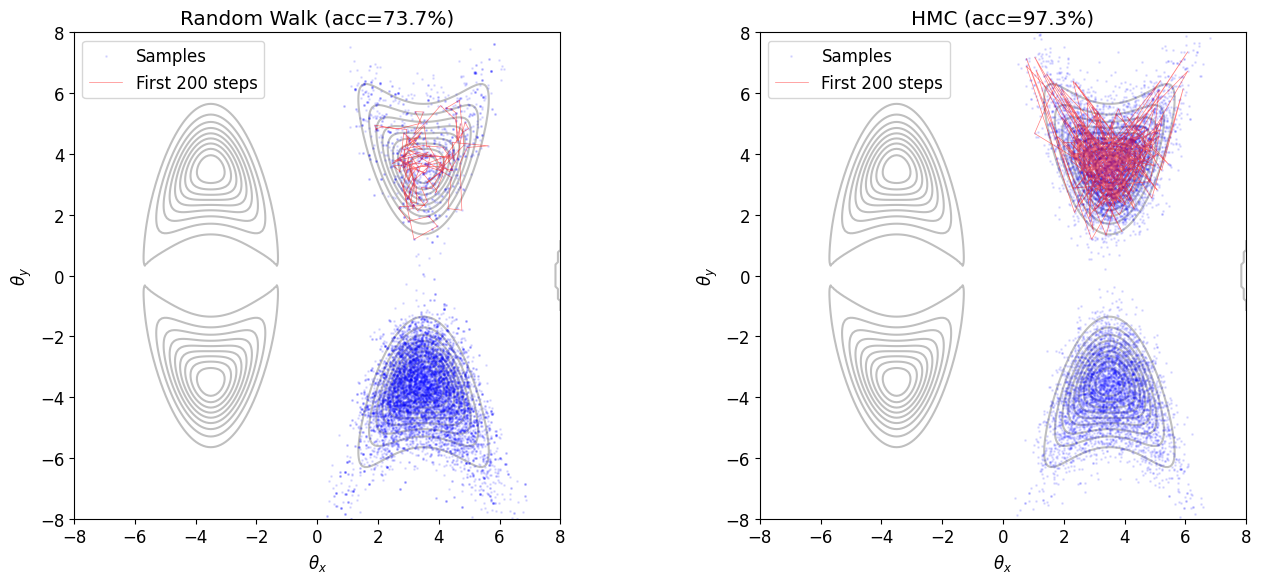

In [24]:
# Visualize samples from both methods
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Background contours
for ax in axes:
    ax.contour(X, Y, jnp.exp(log_probs), levels=10, colors="gray", alpha=0.5)
    ax.set_xlabel(r"$\theta_x$")
    ax.set_ylabel(r"$\theta_y$")
    ax.set_xlim(-8, 8)
    ax.set_ylim(-8, 8)
    ax.set_aspect("equal")

# Random walk samples
axes[0].plot(rw_samples[:, 0], rw_samples[:, 1], "b.", alpha=0.1, markersize=2, label="Samples")
axes[0].plot(rw_samples[:200, 0], rw_samples[:200, 1], "r-", alpha=0.5, linewidth=0.5, label="First 200 steps")
axes[0].set_title(f"Random Walk (acc={rw_acc:.1%})")
axes[0].legend(loc="upper left")

# HMC samples
axes[1].plot(hmc_samples[:, 0], hmc_samples[:, 1], "b.", alpha=0.1, markersize=2, label="Samples")
axes[1].plot(hmc_samples[:200, 0], hmc_samples[:200, 1], "r-", alpha=0.5, linewidth=0.5, label="First 200 steps")
axes[1].set_title(f"HMC (acc={hmc_acc:.1%})")
axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

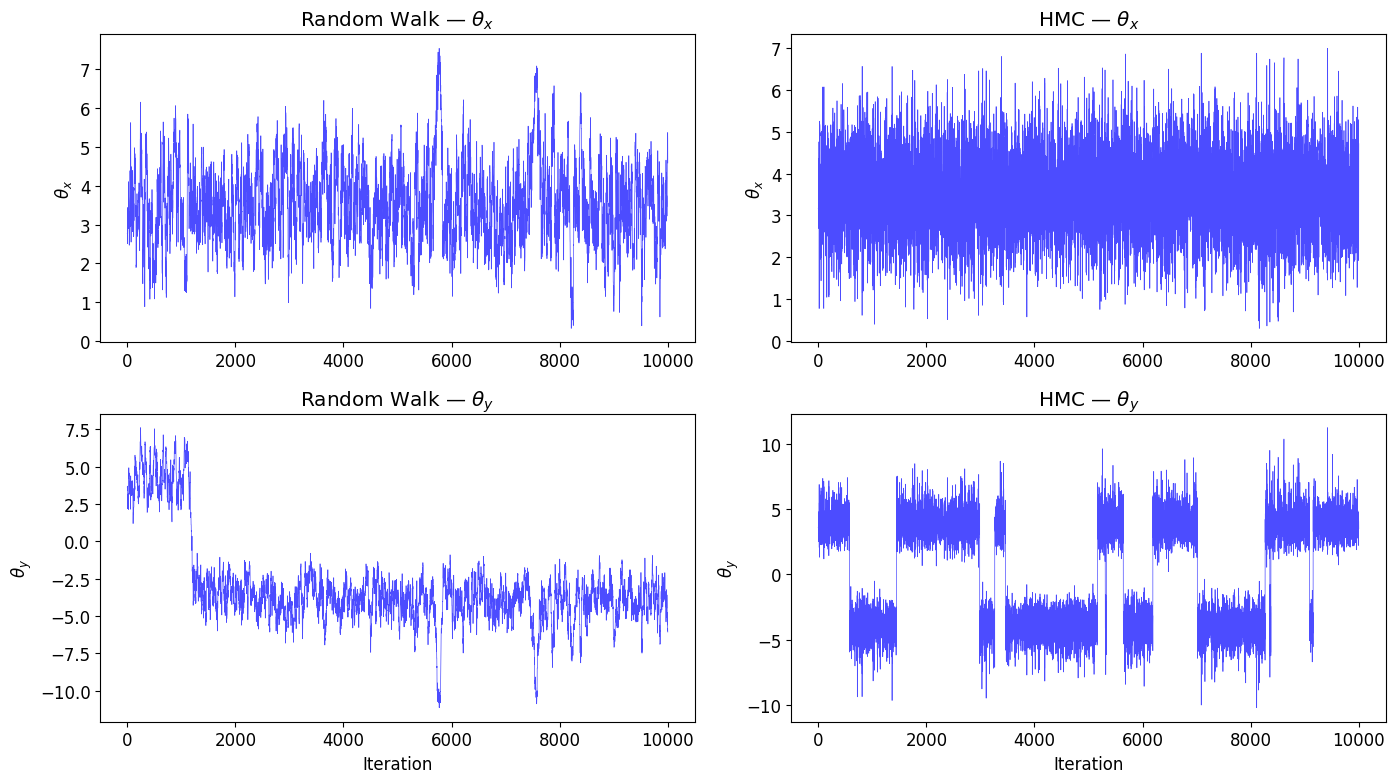

In [25]:
# Trace plots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Random Walk traces
axes[0, 0].plot(rw_samples[:, 0], "b-", alpha=0.7, linewidth=0.5)
axes[0, 0].set_ylabel(r"$\theta_x$")
axes[0, 0].set_title(r"Random Walk — $\theta_x$")

axes[1, 0].plot(rw_samples[:, 1], "b-", alpha=0.7, linewidth=0.5)
axes[1, 0].set_ylabel(r"$\theta_y$")
axes[1, 0].set_xlabel("Iteration")
axes[1, 0].set_title(r"Random Walk — $\theta_y$")

# HMC traces
axes[0, 1].plot(hmc_samples[:, 0], "b-", alpha=0.7, linewidth=0.5)
axes[0, 1].set_ylabel(r"$\theta_x$")
axes[0, 1].set_title(r"HMC — $\theta_x$")

axes[1, 1].plot(hmc_samples[:, 1], "b-", alpha=0.7, linewidth=0.5)
axes[1, 1].set_ylabel(r"$\theta_y$")
axes[1, 1].set_xlabel("Iteration")
axes[1, 1].set_title(r"HMC — $\theta_y$")

plt.tight_layout()
plt.show()

In [26]:
import arviz as az

# Convert samples to arviz InferenceData format
rw_data = az.convert_to_inference_data({"theta_x": rw_samples[None, :, 0], "theta_y": rw_samples[None, :, 1]})
hmc_data = az.convert_to_inference_data({"theta_x": hmc_samples[None, :, 0], "theta_y": hmc_samples[None, :, 1]})

# Compute ESS (R̂ requires multiple chains, so we skip it here)
print("Effective Sample Size (ESS):")
print(f"  Random Walk: θ_x={az.ess(rw_data)['theta_x'].values:.0f}, θ_y={az.ess(rw_data)['theta_y'].values:.0f}")
print(f"  HMC:         θ_x={az.ess(hmc_data)['theta_x'].values:.0f}, θ_y={az.ess(hmc_data)['theta_y'].values:.0f}")

# ESS improvement
rw_min_ess = min(az.ess(rw_data)["theta_x"].values, az.ess(rw_data)["theta_y"].values)
hmc_min_ess = min(az.ess(hmc_data)["theta_x"].values, az.ess(hmc_data)["theta_y"].values)
print(f"\nESS improvement factor: {hmc_min_ess / max(rw_min_ess, 1):.1f}x")

/Users/tsing/Study/bioinformatics/DS595/lab02-starter/.venv/lib/python3.13/site-packages/arviz/__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


Effective Sample Size (ESS):
  Random Walk: θ_x=266, θ_y=5
  HMC:         θ_x=6276, θ_y=29

ESS improvement factor: 5.8x


---

## Part E: Hyperparameter Exploration (~10 min)

Explore how the step size (`epsilon`) affects HMC performance.


In [33]:
# experiment with different step sizes
# episolon mimics determines how well the computer mimics physics
# high precision: small e, low precision: large e
# large e, breaks the physics

epsilons = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
results = []

key = jr.PRNGKey(42)
theta_init = jnp.array([3.5, 3.5])

for eps in epsilons:
    key, subkey = jr.split(key)
    try:
        samples, acc = run_hmc_sampler(subkey, log_prob, theta_init, n_samples=1000, epsilon=eps, l=20)
        # compute ess using arviz
        data = az.convert_to_inference_data({"theta_x": samples[none, :, 0]})
        ess = float(az.ess(data)["theta_x"].values)
        results.append((eps, float(acc), ess))
        print(f"ε={eps:.2f}: acceptance={acc:.2%}, ess={ess:.0f}")
    except Exception as e:
        print(f"ε={eps:.2f}: failed ({e})")
        results.append((eps, 0, 0))

ε=0.01: failed (run_hmc_sampler() got an unexpected keyword argument 'l'. Did you mean 'L'?)
ε=0.05: failed (run_hmc_sampler() got an unexpected keyword argument 'l'. Did you mean 'L'?)
ε=0.10: failed (run_hmc_sampler() got an unexpected keyword argument 'l'. Did you mean 'L'?)
ε=0.20: failed (run_hmc_sampler() got an unexpected keyword argument 'l'. Did you mean 'L'?)
ε=0.50: failed (run_hmc_sampler() got an unexpected keyword argument 'l'. Did you mean 'L'?)
ε=1.00: failed (run_hmc_sampler() got an unexpected keyword argument 'l'. Did you mean 'L'?)


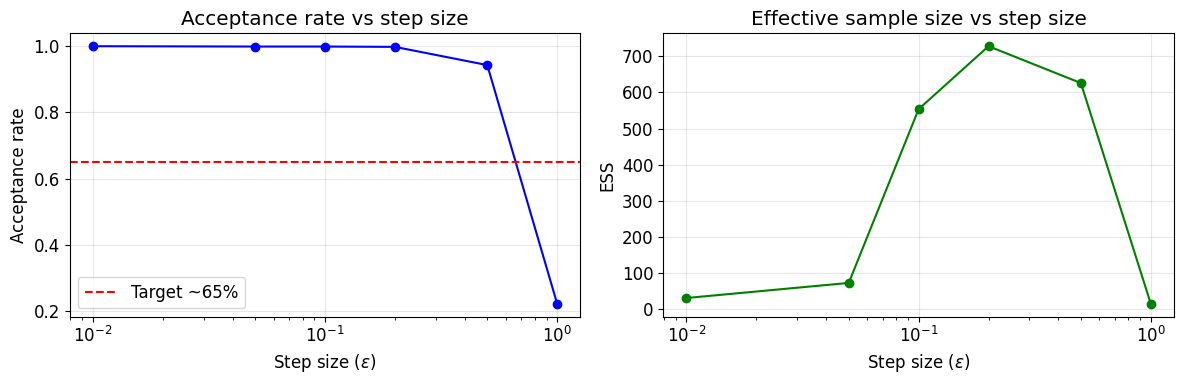

In [28]:
# Plot results
epsilons_arr, accs, ess_vals = zip(*results)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].semilogx(epsilons_arr, accs, "bo-")
axes[0].axhline(y=0.65, color="r", linestyle="--", label="Target ~65%")
axes[0].set_xlabel(r"Step size ($\epsilon$)")
axes[0].set_ylabel("Acceptance rate")
axes[0].set_title("Acceptance rate vs step size")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].semilogx(epsilons_arr, ess_vals, "go-")
axes[1].set_xlabel(r"Step size ($\epsilon$)")
axes[1].set_ylabel("ESS")
axes[1].set_title("Effective sample size vs step size")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Discussion

**HMC vs Random Walk**: You should see that HMC achieves both better exploration of the distribution _and_ higher acceptance rates compared to random walk Metropolis. This is because HMC uses gradient information to make informed proposals that follow the geometry of the posterior, rather than proposing blindly in random directions.

**A warning about diagnostics**: Even though ESS and other diagnostics might look acceptable, the sampler may not have explored all modes! With highly multimodal distributions like our four-banana example, there is no way to tell from ESS alone whether the posterior is faithfully represented. Even $\hat{R}$ can be misleading if you've gotten unlucky and multiple chains all end up in similar modes. Always visualize your samples when possible, and be skeptical of diagnostics on multimodal posteriors. There is no substitute to looking!


---

## Bonus: Multiple Chains

Running multiple chains in parallel lets us compute $\hat{R}$ (which measures convergence by comparing between-chain and within-chain variance) and get more robust ESS estimates. Can you modify `run_hmc_sampler` to run `n_chains` chains in parallel using `jax.vmap`?

**Hint**: You'll need to:

1. Generate different random keys for each chain
2. Use different (or the same) initial positions for each chain
3. `vmap` over the chain dimension
4. Return samples with shape `(n_chains, n_samples, D)`


In [38]:
from jax import grad, random
# Bonus: Implement multiple chains here
def run_hmc_sampler_multi_chain(key, log_prob_fn, theta_init, n_chains, n_samples, epsilon, L):
    """Run multiple HMC chains in parallel.

    Args:
        key: JAX random key
        log_prob_fn: Function that returns log probability
        theta_init: Initial position, shape (D,) - same for all chains
        n_chains: Number of parallel chains
        n_samples: Number of samples per chain
        epsilon: Leapfrog step size
        L: Number of leapfrog steps

    Returns:
        samples: Array of shape (n_chains, n_samples, D)
        acceptance_rates: Array of shape (n_chains,)
    """
    # TODO: Implement this!
    # Hint: Use jr.split to get n_chains different keys, then vmap run_hmc_sampler
    keys = random.split(key, n_chains)

    def single_chain_wrapper(chain_key):
        return run_hmc_sampler(chain_key, log_prob_fn, theta_init, n_samples, epsilon, L)

    # vmap to parallelize 
    multi_chain_fn = jax.vmap(single_chain_wrapper)
    samples, acceptance_rates = multi_chain_fn(keys)

    return samples, acceptance_rates


-   $\hat{R} = 1.0$: Perfect agreement. The chains are indistinguishable from one another.
-   $\hat{R} < 1.05$: The gold standard. Your chains have likely converged, and you can trust your results.
-   $\hat{R} > 1.1$: Warning! Your chains are seeing different things. One might be stuck in a "local mode" (a different peak), or the step size ($\epsilon$) might be too small for them to move effectively.


In [44]:
# Tester
# --- Execution ---
n_chains = 4 # 4 is standard, 9+ is for complex models
n_samples = 1000
D = 2 # 2D Gaussian

key = jr.PRNGKey(42)
theta_start = jnp.array([1.0, 1.0]) # Start slightly off-center

samples, acc_rates = run_hmc_sampler_multi_chain(
    key, log_prob, theta_start, n_chains, n_samples, epsilon=0.1, L=10
)

# --- Validation Checks ---
print(f"Samples shape: {samples.shape}") # Expect (4, 1000, 2)
print(f"Acceptance rates per chain: {acc_rates}") # Rhat scores

# Check if the mean is close to [0, 0]
grand_mean = jnp.mean(samples, axis=(0, 1))
print(f"Estimated Mean: {grand_mean}")

Samples shape: (4, 1000, 2)
Acceptance rates per chain: [1.        0.9990001 0.998     0.9990001]
Estimated Mean: [3.5426037 3.447277 ]
